In [80]:
#Step 0
import os
import numpy as np
import soundfile as sf

dataset_root = "/kaggle/input/fan-and-valve"
preprocessed_root = "/kaggle/working/preprocessed_augmented/fan-and-valve"
os.makedirs(preprocessed_root, exist_ok=True)

clip_duration = 5  # seconds
stride = 1.25
sample_rate = 16000
classes = ["fan", "valve"]

for cls in classes:
    cls_dir = os.path.join(dataset_root, cls, cls)
    audio_files = [f for f in os.listdir(cls_dir) if f.endswith(".wav")]
    clip_count = 0
    for audio_file in audio_files:
        audio_path = os.path.join(cls_dir, audio_file)
        audio, sr = sf.read(audio_path)
        if sr != sample_rate:
            continue
        total_samples = len(audio)
        samples_per_clip = clip_duration * sample_rate
        stride_samples = int(stride * sample_rate)
        start = 0
        while start + samples_per_clip <= total_samples:
            audio_clip = audio[start:start + samples_per_clip]
            clip_dir = os.path.join(preprocessed_root, cls, f"clip_{clip_count:04d}")
            os.makedirs(clip_dir, exist_ok=True)
            np.save(os.path.join(clip_dir, "audio.npy"), audio_clip)
            # Placeholder frames
            np.save(os.path.join(clip_dir, "frames.npy"), np.zeros((75,224,224,3), dtype=np.uint8))
            clip_count += 1
            start += stride_samples
        # Ensure at least 100 clips per class
        while clip_count < 100:
            rand_idx = np.random.randint(0, clip_count)
            existing_clip = os.path.join(preprocessed_root, cls, f"clip_{rand_idx:04d}")
            audio = np.load(os.path.join(existing_clip, "audio.npy"))
            frames = np.load(os.path.join(existing_clip, "frames.npy"))
            clip_dir = os.path.join(preprocessed_root, cls, f"clip_{clip_count:04d}")
            os.makedirs(clip_dir, exist_ok=True)
            np.save(os.path.join(clip_dir, "audio.npy"), audio)
            np.save(os.path.join(clip_dir, "frames.npy"), frames)
            clip_count += 1

In [81]:
#Step 1
import os
import numpy as np
import math
import pandas as pd

src_root = "/kaggle/working/preprocessed/fan-and-valve"
dst_root = "/kaggle/working/preprocessed_augmented/fan-and-valve"
os.makedirs(dst_root, exist_ok=True)

window_frames = 75
stride_frames = 15
audio_rate = 16000
window_audio = 5 * audio_rate
stride_audio = 1 * audio_rate

metadata = []

for cls in os.listdir(src_root):
    cls_src = os.path.join(src_root, cls)
    cls_dst = os.path.join(dst_root, cls)
    os.makedirs(cls_dst, exist_ok=True)
    for clip in os.listdir(cls_src):
        clip_dir = os.path.join(cls_src, clip)
        frames_path = os.path.join(clip_dir, "frames.npy")
        audio_path = os.path.join(clip_dir, "audio.npy")
        if not os.path.exists(frames_path) or not os.path.exists(audio_path):
            continue
        frames = np.load(frames_path)
        audio = np.load(audio_path)
        num_aug = math.floor((len(frames) - window_frames)/stride_frames) + 1
        for i in range(num_aug):
            f_start, f_end = i*stride_frames, i*stride_frames+window_frames
            a_start, a_end = i*stride_audio, i*stride_audio+window_audio
            if f_end > len(frames) or a_end > len(audio):
                break
            out_dir = os.path.join(cls_dst, f"{clip}_aug{i:02d}")
            os.makedirs(out_dir, exist_ok=True)
            np.save(os.path.join(out_dir, "frames.npy"), frames[f_start:f_end])
            np.save(os.path.join(out_dir, "audio.npy"), audio[a_start:a_end])
            metadata.append({
                "class": cls,
                "original_clip": clip,
                "augmented_clip": f"{clip}_aug{i:02d}"
            })

metadata_df = pd.DataFrame(metadata)
metadata_path = "/kaggle/working/split_metadata.csv"
metadata_df.to_csv(metadata_path, index=False)

In [82]:
#Step 2
import os
import numpy as np

dataset_root = "/kaggle/working/preprocessed/fan-and-valve"
augmented_root = "/kaggle/working/preprocessed_augmented/fan-and-valve"
os.makedirs(augmented_root, exist_ok=True)

clip_duration = 5.0
sample_rate = 16000
stride = 0.25
samples_per_clip = int(clip_duration * sample_rate)
stride_samples = int(stride * sample_rate)

for class_name in ["fan","valve"]:
    class_dir = os.path.join(dataset_root,class_name)
    output_dir = os.path.join(augmented_root,class_name)
    os.makedirs(output_dir,exist_ok=True)
    clip_counter = 0
    for clip_folder in sorted(os.listdir(class_dir)):
        clip_path = os.path.join(class_dir, clip_folder)
        audio_path = os.path.join(clip_path,"audio.npy")
        frames_path = os.path.join(clip_path,"frames.npy")
        if not os.path.exists(audio_path) or not os.path.exists(frames_path):
            continue
        audio = np.load(audio_path)
        frames = np.load(frames_path)
        for start in range(0,len(audio)-samples_per_clip+1,stride_samples):
            end = start + samples_per_clip
            audio_slice = audio[start:end]
            out_dir = os.path.join(output_dir,f"{clip_folder}_aug_{clip_counter:04d}")
            os.makedirs(out_dir,exist_ok=True)
            np.save(os.path.join(out_dir,"audio.npy"),audio_slice)
            np.save(os.path.join(out_dir,"frames.npy"),frames)
            clip_counter += 1

In [83]:
#Step 3
import os
import numpy as np
import pandas as pd

preprocessed_root = "/kaggle/working/preprocessed_augmented/fan-and-valve"
report = []

for class_name in ["fan","valve"]:
    class_dir = os.path.join(preprocessed_root,class_name)
    if not os.path.exists(class_dir):
        continue
    clip_dirs = [os.path.join(class_dir,d) for d in os.listdir(class_dir) if os.path.isdir(os.path.join(class_dir,d))]
    for clip_dir in clip_dirs:
        frames_path = os.path.join(clip_dir,"frames.npy")
        audio_path = os.path.join(clip_dir,"audio.npy")
        frames_shape = None
        audio_shape = None
        if os.path.exists(frames_path):
            frames_shape = np.load(frames_path).shape
        if os.path.exists(audio_path):
            audio_shape = np.load(audio_path).shape
        report.append({
            "class": class_name,
            "clip": os.path.basename(clip_dir),
            "frames_shape": frames_shape,
            "audio_shape": audio_shape
        })

df = pd.DataFrame(report)
summary = df.groupby("class").size().reset_index(name="total_clips")

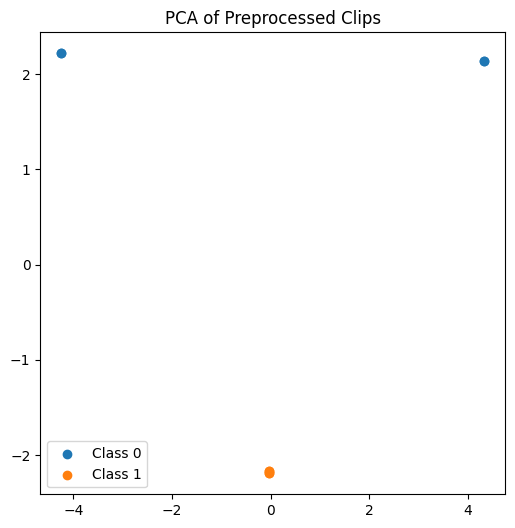

In [84]:
# Step 4: Embedding Verification & Visualization
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

preprocessed_root = "/kaggle/working/preprocessed_augmented/fan-and-valve"
report = []
labels = []

for cls in ["fan", "valve"]:
    cls_dir = os.path.join(preprocessed_root, cls)
    clip_dirs = [os.path.join(cls_dir, d) for d in os.listdir(cls_dir) if os.path.isdir(os.path.join(cls_dir, d))]
    for clip_dir in clip_dirs:
        frames_path = os.path.join(clip_dir, "frames.npy")
        audio_path = os.path.join(clip_dir, "audio.npy")
        if os.path.exists(frames_path) and os.path.exists(audio_path):
            report.append(np.concatenate([np.load(frames_path).flatten(), np.load(audio_path).flatten()]))
            labels.append(cls)

X = np.array(report)
y = LabelEncoder().fit_transform(labels)

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)
plt.figure(figsize=(6,6))
for label in np.unique(y):
    plt.scatter(X_2d[y==label,0], X_2d[y==label,1], label=f"Class {label}")
plt.title("PCA of Preprocessed Clips")
plt.legend()
plt.show()

#Step 4
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.video import r3d_18
from PIL import Image
import torchaudio

base_dir = "/kaggle/working/preprocessed_augmented"
embed_dir = "/kaggle/working/embeddings"
os.makedirs(embed_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
video_model = r3d_18(weights="KINETICS400_V1")
video_model.fc = torch.nn.Identity()
video_model = video_model.to(device).eval()

audio_bundle = torchaudio.pipelines.WAV2VEC2_BASE
audio_model = audio_bundle.get_model().to(device).eval()

transform = T.Compose([
    T.Resize((112, 112)),
    T.ToTensor(),
    T.Normalize(mean=[0.43216, 0.394666, 0.37645],
                std=[0.22803, 0.22145, 0.216989]),
])

def extract_visual_features(video_frames):
    frames = torch.stack([transform(Image.fromarray(f.astype(np.uint8))) for f in video_frames])
    frames = frames.permute(1, 0, 2, 3).unsqueeze(0).float().to(device)
    with torch.no_grad():
        feats = video_model(frames)
    return feats.squeeze(0).cpu().numpy()

def extract_audio_features(audio_waveform):
    waveform = torch.tensor(audio_waveform, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        feats, _ = audio_model.extract_features(waveform)
    return feats[-1].squeeze(0).cpu().numpy()

for cls in os.listdir(base_dir):
    cls_path = os.path.join(base_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    for clip in os.listdir(cls_path):
        clip_path = os.path.join(cls_path, clip)
        frames_path = os.path.join(clip_path, "frames.npy")
        audio_path = os.path.join(clip_path, "audio.npy")
        try:
            if os.path.exists(frames_path):
                frames = np.load(frames_path)
                vis_feats = extract_visual_features(frames)
                np.save(os.path.join(embed_dir, f"{cls}_{clip}_visual.npy"), vis_feats)
            if os.path.exists(audio_path):
                audio = np.load(audio_path)
                aud_feats = extract_audio_features(audio)
                np.save(os.path.join(embed_dir, f"{cls}_{clip}_audio.npy"), aud_feats)
        except Exception as e:
            print(f"Error in {cls}/{clip}: {e}")


In [85]:
#Step 5
import os
import numpy as np
import torch
import torch.nn as nn

EMB_ROOT = "/kaggle/working/embeddings"
FUSED_ROOT = "/kaggle/working/embeddings/fused"
os.makedirs(FUSED_ROOT, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CrossAttentionFusion(nn.Module):
    def __init__(self, v_dim, a_dim, hidden=512, nheads=8, out_dim=512):
        super().__init__()
        self.v_proj = nn.Linear(v_dim, hidden)
        self.a_proj = nn.Linear(a_dim, hidden)
        self.attn = nn.MultiheadAttention(embed_dim=hidden, num_heads=nheads, batch_first=True)
        self.ff = nn.Sequential(nn.Linear(hidden * 2, out_dim), nn.ReLU(), nn.Linear(out_dim, out_dim))
    def forward(self, v, a):
        if v.ndim == 1: v = v.unsqueeze(0).unsqueeze(1)
        elif v.ndim == 2: v = v.unsqueeze(0)
        if a.ndim == 1: a = a.unsqueeze(0).unsqueeze(1)
        elif a.ndim == 2: a = a.unsqueeze(0)
        v_h = self.v_proj(v.float())
        a_h = self.a_proj(a.float())
        attn_out, _ = self.attn(query=v_h, key=a_h, value=a_h)
        a_pool = a_h.mean(dim=1, keepdim=True)
        cat = torch.cat([attn_out, a_pool], dim=-1).squeeze(1)
        return self.ff(cat)

visual_files = [f for f in os.listdir(EMB_ROOT) if f.endswith("_visual.npy")]
audio_files = [f for f in os.listdir(EMB_ROOT) if f.endswith("_audio.npy")]
clip_ids = set(f.replace("_visual.npy", "") for f in visual_files) & set(f.replace("_audio.npy", "") for f in audio_files)

if not clip_ids:
    raise ValueError("No matching visual/audio embeddings found!")

sample_v = np.load(os.path.join(EMB_ROOT, visual_files[0]))
sample_a = np.load(os.path.join(EMB_ROOT, audio_files[0]))
v_dim, a_dim = sample_v.shape[-1], sample_a.shape[-1]
model = CrossAttentionFusion(v_dim=v_dim, a_dim=a_dim).to(device).eval()

for cid in sorted(clip_ids):
    v = np.load(os.path.join(EMB_ROOT, f"{cid}_visual.npy"))
    a = np.load(os.path.join(EMB_ROOT, f"{cid}_audio.npy"))
    if v.ndim == 1: v = v.reshape(1, -1)
    if a.ndim == 1: a = a.reshape(1, -1)
    v_tensor = torch.from_numpy(v).float().to(device)
    a_tensor = torch.from_numpy(a).float().to(device)
    with torch.no_grad():
        fused = model(v_tensor, a_tensor).cpu().numpy()
    np.save(os.path.join(FUSED_ROOT, f"{cid}_fused.npy"), fused)

In [ ]:
import os, json, numpy as np, torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

emb_dir = "/kaggle/working/embeddings/fused"
results_dir = "/kaggle/working/results"
os.makedirs(results_dir, exist_ok=True)

X, y = [], []
for f in os.listdir(emb_dir):
    if f.endswith(".npy"):
        arr = np.load(os.path.join(emb_dir, f))
        arr = arr.flatten() if arr.ndim > 1 else arr
        X.append(arr)
        label = f.split("_")[1] if "_" in f else "unknown"
        y.append(label)

X, y = np.array(X), np.array(y)
le = LabelEncoder()
y_enc = le.fit_transform(y)
X_tensor = torch.tensor(X, dtype=torch.float32)
num_classes = len(np.unique(y_enc))
input_dim = X_tensor.shape[1]

class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        if x.ndim == 1: x = x.unsqueeze(0)
        return self.softmax(self.fc2(self.drop(self.relu(self.fc1(x)))))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_acc, all_prec, all_rec, all_f1 = [], [], [], []

for train_idx, test_idx in skf.split(X_tensor, y_enc):
    X_train, X_test = X_tensor[train_idx].to(device), X_tensor[test_idx].to(device)
    y_train, y_test = torch.tensor(y_enc[train_idx]).to(device), torch.tensor(y_enc[test_idx]).to(device)

    model = Classifier(input_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

    for epoch in range(25):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(X_test).argmax(1).cpu().numpy()
    y_test_cpu = y_test.cpu().numpy()
    acc = accuracy_score(y_test_cpu, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test_cpu, preds, average="weighted", zero_division=0)
    all_acc.append(acc)
    all_prec.append(prec)
    all_rec.append(rec)
    all_f1.append(f1)

metrics = {
    "accuracy": float(np.mean(all_acc)),
    "precision": float(np.mean(all_prec)),
    "recall": float(np.mean(all_rec)),
    "f1_score": float(np.mean(all_f1))
}

with open(os.path.join(results_dir, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=4)

print(metrics)
